# Multivariate QuasiCopula GWAS with Mixed Marginals

Here we assume each sample have $d$ observations, and we estimate a general covariance matrix 

$$\mathbf{\Gamma} = \mathbf{L}\mathbf{L}^t$$

In [1]:
using Revise
using DataFrames, Random, GLM, QuasiCopula
using ForwardDiff, Test, LinearAlgebra
using LinearAlgebra: BlasReal, copytri!
using ToeplitzMatrices
using BenchmarkTools
using SnpArrays
using Statistics
using StatsBase
using MendelPlots

ENV["COLUMNS"] = 240
BLAS.set_num_threads(1)
Threads.nthreads()

Precompiling QuasiCopula
  ✓ QuasiCopula
  1 dependency successfully precompiled in 5 seconds. 165 already precompiled.


1

## Simulate data

In [16]:
k = 0 # number of causal SNPs

qc_model, G, Btrue, Γtrue, γtrue, τtrue = simulate_multivariate_traits(
    n = 1000, # sample size
    p = 3, # number of fixed effects, including intercept
    m = 2, # number of variance components
    d = 4, # number of phenotypes
    q = 100, # number of SNPs
    k = k, # number of causal SNPs
#     Γ = Matrix(SymmetricToeplitz(0.5.^(0:(d-1)))),
    seed = 2024,
    τtrue = 0.1,
    possible_distributions = [Normal, Bernoulli, Poisson],
);

In [17]:
# phenotypes
qc_model.data.Y

1000×4 Matrix{Float64}:
  0.465505  0.0  0.0  1.0
  2.43812   1.0  1.0  1.0
 -5.64098   0.0  0.0  1.0
  3.86844   1.0  0.0  0.0
 -4.48907   1.0  0.0  0.0
 -2.56907   0.0  1.0  1.0
 -4.01377   1.0  1.0  2.0
  1.62033   2.0  0.0  1.0
  3.74973   2.0  0.0  3.0
  2.91689   0.0  1.0  0.0
 -4.7109    1.0  0.0  0.0
 -3.28293   1.0  1.0  3.0
 -2.7223    0.0  0.0  1.0
  ⋮                   
 -5.60909   0.0  0.0  0.0
  1.4915    1.0  0.0  2.0
 -4.52557   0.0  0.0  1.0
 -0.160964  0.0  0.0  1.0
 -2.73165   0.0  0.0  5.0
 -4.04717   0.0  1.0  2.0
 -1.40839   1.0  0.0  4.0
  2.73641   1.0  1.0  2.0
 -1.73719   2.0  1.0  2.0
 -2.34671   0.0  0.0  0.0
 -3.03835   0.0  0.0  1.0
  0.254     1.0  0.0  0.0

In [18]:
Statistics.cor(qc_model.data.Y)

4×4 Matrix{Float64}:
  1.0        0.183815   0.056916   -0.0166072
  0.183815   1.0        0.0459901   0.0601929
  0.056916   0.0459901  1.0         0.0387637
 -0.0166072  0.0601929  0.0387637   1.0

In [19]:
Γtrue

4×4 Matrix{Float64}:
 1.0    0.5   0.25  0.125
 0.5    1.0   0.5   0.25
 0.25   0.5   1.0   0.5
 0.125  0.25  0.5   1.0

## Fit Null model

In [20]:
@time optm = QuasiCopula.fit!(qc_model);

par[1] = -0.20287322909369346
par[1] = -0.20287322909369346
par[1] = -0.20287322909369346
par[1] = -0.20287322909369346
par[1] = -0.20287322909369346
This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       23
                     variables with only lower bounds:        1
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    

┌ Warning: Optimization unsuccesful; got INVALID_MODEL
└ @ QuasiCopula ~/.julia/dev/QuasiCopula/src/gwas/multivariate.jl:218


In [12]:
# compare beta
[vec(qc_model.B) vec(Btrue)]

12×2 Matrix{Float64}:
  -0.504132   -0.385704
   0.108127   -0.054207
  -0.608272   -0.394284
   0.410668   -0.420927
  -0.0304512   0.0878788
   0.173584   -0.493356
 -45.6477      0.2951
   8.07168    -0.456848
 -47.2299     -0.368505
   0.186944   -0.367624
   0.180792    0.242028
  -0.0133134  -0.38976

In [14]:
# compare Γ
L = qc_model.L
[vec(Γtrue) vec(cov2cor(L.L*L.L'))]

16×2 Matrix{Float64}:
 1.0     1.0
 0.5    -0.0778598
 0.25   -0.0187545
 0.125  -0.012791
 0.5    -0.0778598
 1.0     1.0
 0.5     0.0338054
 0.25    0.0799054
 0.25   -0.0187545
 0.5     0.0338054
 1.0     1.0
 0.5     0.0303901
 0.125  -0.012791
 0.25    0.0799054
 0.5     0.0303901
 1.0     1.0

In [15]:
# compare nuisance parameters 
[qc_model.ϕ [τtrue for _ in 1:length(qc_model.ϕ)]]

1×2 Matrix{Float64}:
 76.3186  0.1

## Score test GWAS

In [8]:
pvals = multivariateGWAS_autodiff(qc_model, G)

Progress: 100%|█████████████████████████████████████████| Time: 0:08:51


100-element Vector{Float64}:
 0.31925271875024414
 0.36208833083857833
 0.2507538241812135
 0.2954134372396186
 0.2342595067117617
 0.9783282926558374
 0.3261639480887088
 0.47718781829720003
 0.061993848045111925
 0.8266281487555684
 0.6511929399313756
 0.45654141490611094
 0.3073575386742658
 ⋮
 0.11398302430725075
 0.40857119199876046
 0.079591708602425
 0.879063617169675
 0.09082056194352087
 0.9102083840725187
 0.7705485149935084
 0.6117564554428817
 0.9947972926995126
 0.4260554312563645
 0.014392088255771722
 0.05782980422681136

In [101]:
pvals = multivariateGWAS_autodiff(qc_model, G)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


1000-element Vector{Float64}:
 0.26050430296126986
 0.10468696211683476
 0.2031327503062303
 0.17307949915577855
 0.98296768904625
 0.894789310674496
 0.006090504857996004
 0.29090239144086033
 0.5583774083569042
 0.7331048604642944
 0.6514439973388421
 0.2372939606970496
 0.25622220029010206
 ⋮
 0.9982050542129816
 0.8237452478615934
 0.7348102502658302
 0.5319841674520592
 0.29766096338133824
 0.23644548763162423
 0.021709859825077754
 0.5132287019408608
 0.9370461420563777
 0.4814231333217101
 0.9253902061244873
 0.7914789923468943

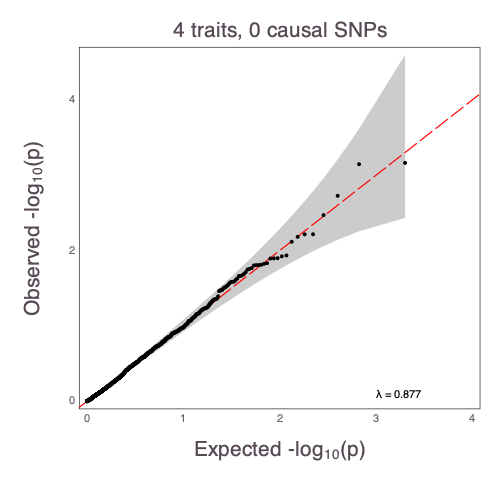

In [102]:
# 2 normal, 1 bernoulli, 1 poisson
qq(pvals, dpi=100, titles="4 traits, $k causal SNPs")
display("image/png", read("qqplot.png"))

In [1]:
using Revise
using DataFrames, Random, GLM, QuasiCopula
using ForwardDiff, Test, LinearAlgebra
using LinearAlgebra: BlasReal, copytri!
using ToeplitzMatrices
using BenchmarkTools
using SnpArrays
using Statistics
using StatsBase
using MendelPlots

BLAS.set_num_threads(1)

function simulate_random_snparray(s::Union{String, UndefInitializer}, n::Int64,
    p::Int64; mafs::Vector{Float64}=zeros(Float64, p), min_ma::Int = 5)

    #first simulate a random {0, 1, 2} matrix with each SNP drawn from Binomial(2, r[i])
    A1 = BitArray(undef, n, p) 
    A2 = BitArray(undef, n, p) 
    for j in 1:p
        minor_alleles = 0
        maf = 0
        while minor_alleles <= min_ma
            maf = 0.5rand()
            for i in 1:n
                A1[i, j] = rand(Bernoulli(maf))
                A2[i, j] = rand(Bernoulli(maf))
            end
            minor_alleles = sum(view(A1, :, j)) + sum(view(A2, :, j))
        end
        mafs[j] = maf
    end

    #fill the SnpArray with the corresponding x_tmp entry
    return _make_snparray(s, A1, A2)
end

function _make_snparray(s::Union{String, UndefInitializer}, A1::BitArray, A2::BitArray)
    n, p = size(A1)
    x = SnpArray(s, n, p)
    for i in 1:(n*p)
        c = A1[i] + A2[i]
        if c == 0
            x[i] = 0x00
        elseif c == 1
            x[i] = 0x02
        elseif c == 2
            x[i] = 0x03
        else
            throw(MissingException("matrix shouldn't have missing values!"))
        end
    end
    return x
end

[ Info: Precompiling QuasiCopula [c47b6ae2-b804-4668-9957-eb588c99ffbc]


_make_snparray (generic function with 1 method)

## Simulate data

Given $n$ independent samples, we simulate phenotypes from 
$$\mathbf{y}_i \sim QC(\mathbf{\Gamma}, f_1, ..., f_d)$$

In [2]:
# simulate data
p = 3    # number of fixed effects, including intercept
m = 2    # number of variance componentsac
n = 5000 # number of sample
d = 4    # number of phenotypes per sample
q = 1000 # number of SNPs
k = 5    # number of causal SNPs

# sample d marginal distributions for each phenotype within samples
Random.seed!(1234)
possible_distributions = [Normal, Bernoulli, Poisson]
vecdist = rand(possible_distributions, d)
# vecdist = [Poisson, Bernoulli, Bernoulli] # this derivative test is fine
# vecdist = [Bernoulli, Bernoulli, Poisson] # this derivative test is wrong everywhere
veclink = [canonicallink(vecdist[j]()) for j in 1:d]

# simulate nongenetic coefficient and variance component params
Random.seed!(2022)
τtrue = 10.0
Btrue = rand(Uniform(-0.5, 0.5), p, d)
θtrue = fill(0.4, m)
V1 = ones(d, d)
V2 = Matrix(I, d, d)
Γ = m == 1 ? θtrue[1] * V1 : θtrue[1] * V1 + θtrue[2] * V2
# Γ = 0.5.*ones(d, d) + 0.5I

# simulate non-genetic design matrix
Random.seed!(2022)
X = [ones(n) randn(n, p - 1)]

# simulate random SnpArray with q SNPs and randomly choose k SNPs to be causal
# here the first phenotype has strong effect, while other phenotypes have decreasing effects
Random.seed!(2022)
G = simulate_random_snparray(undef, n, q)
Gfloat = convert(Matrix{Float64}, G, center=true, scale=true)
γtrue = zeros(q, d)
causal_snps = sample(1:q, k, replace=false) |> sort
γtrue[causal_snps, 1] .= rand([-0.2, 0.2], k)
for j in 2:d
    γtrue[causal_snps, j] .= 0.5^j .* γtrue[causal_snps, 1]
end

# sample phenotypes
Y = zeros(n, d)
y = Vector{Float64}(undef, d)
for i in 1:n
    Xi = X[i, :]
    Gi = Gfloat[i, :]
    η = Btrue' * Xi + γtrue' * Gi
    vecd_tmp = Vector{UnivariateDistribution}(undef, d)
    for j in 1:d
        dist = vecdist[j]
        μj = GLM.linkinv(canonicallink(dist()), η[j])
        if dist == Normal
            σ2 = inv(τtrue)
            σ = sqrt(σ2)
            vecd_tmp[j] = Normal(μj, σ)
        else
            vecd_tmp[j] = dist(μj)
        end
    end
    multivariate_dist = MultivariateMix(vecd_tmp, Γ)
    res = Vector{Float64}(undef, d)
    rand(multivariate_dist, y, res)
    Y[i, :] .= y
end

# form model
V = m == 1 ? [V1] : [V1, V2]
qc_model = MultivariateCopulaVCModel(Y, X, V, vecdist, veclink, penalized=false);

What does phenotypes look like?

In [3]:
Y

5000×4 Matrix{Float64}:
 -1.28163    0.0  -0.415917   1.0
  0.570392   1.0  -0.437541   0.0
 -0.899075   0.0   0.626361   3.0
  1.39392    0.0  -0.0704303  0.0
 -0.52449    0.0   0.855822   1.0
 -0.818395   0.0   0.126965   0.0
 -0.0120305  1.0  -0.117696   0.0
  0.145072   1.0  -0.261022   1.0
 -0.302563   0.0   0.575371   2.0
 -0.636933   1.0  -0.0159948  0.0
  0.80406    1.0   0.66775    0.0
  0.304521   0.0   0.146666   1.0
 -0.0235421  0.0   1.06856    0.0
  ⋮                           
 -0.892895   0.0  -0.0771152  1.0
 -1.04522    1.0   0.987614   1.0
 -0.341696   0.0   0.097902   1.0
 -0.459006   1.0  -0.647328   0.0
  0.828123   1.0  -0.95536    0.0
  0.541685   0.0  -0.0932948  0.0
 -0.264861   0.0   0.58193    2.0
 -0.238232   1.0   0.131018   1.0
 -0.733315   1.0   0.890936   2.0
  1.24784    1.0   0.441328   2.0
 -0.0424797  1.0   0.691514   0.0
 -1.0805     0.0  -0.662316   0.0

What does our covariates look like?

In [4]:
X

5000×3 Matrix{Float64}:
 1.0  -0.308648    1.70162
 1.0   1.67671    -0.548034
 1.0  -0.347153    0.736227
 1.0   0.818666   -2.16009
 1.0  -1.71753    -0.273745
 1.0  -0.238934    0.942883
 1.0   0.701932    1.02868
 1.0  -0.166138   -0.278824
 1.0  -0.609614    0.289359
 1.0   0.68791     0.209478
 1.0   0.0342303  -0.543192
 1.0  -0.479078   -0.865401
 1.0  -1.63537     0.348029
 ⋮                
 1.0   0.200555    1.14607
 1.0  -0.205806    1.98172
 1.0   1.17812     0.307879
 1.0   1.60549     0.817788
 1.0   1.63509    -0.960082
 1.0  -0.446096   -1.0502
 1.0   0.632009   -0.335688
 1.0   0.589777   -1.92135
 1.0  -0.542628    1.68057
 1.0  -0.779274    0.6376
 1.0  -1.19111    -1.3064
 1.0   0.505272    1.11117

True SNP effects

In [5]:
γtrue[findall(!iszero, γtrue)]

20-element Vector{Float64}:
  0.2
  0.2
 -0.2
  0.2
 -0.2
  0.05
  0.05
 -0.05
  0.05
 -0.05
  0.025
  0.025
 -0.025
  0.025
 -0.025
  0.0125
  0.0125
 -0.0125
  0.0125
 -0.0125

Support for the phenotypes

In [6]:
vecdist

4-element Vector{UnionAll}:
 Normal
 Bernoulli
 Normal
 Poisson

In [7]:
# true Γ scaled to correlation matrix
cov2cor(Γ, diag(Γ))

4×4 Matrix{Float64}:
 1.0    0.625  0.625  0.625
 0.625  1.0    0.625  0.625
 0.625  0.625  1.0    0.625
 0.625  0.625  0.625  1.0

In [8]:
# empirical correlation of Y
Statistics.cor(Y)

4×4 Matrix{Float64}:
  1.0          0.152808    -0.0922782   0.00906314
  0.152808     1.0         -0.00659099  0.106106
 -0.0922782   -0.00659099   1.0         0.107757
  0.00906314   0.106106     0.107757    1.0

## Fit Null model

TODO: 

+ Initializing $\theta$ and $\phi$ in a better way

In [9]:
@time optm = QuasiCopula.fit!(qc_model,
    Ipopt.IpoptSolver(
        print_level = 5, 
        tol = 10^-6, 
        max_iter = 100,
        accept_after_max_steps = 10,
        warm_start_init_point="yes", 
        limited_memory_max_history = 6, # default value
        hessian_approximation = "limited-memory",
        derivative_test="first-order"
    )
);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Starting derivative checker for first derivatives.

* grad_f[          1] = -1.4619264826688592e+05    ~ -3.8115290395940460e+03  [ 3.736e+01]
* grad_f[          2] = -1.6032031101563740e+04    ~ -4.6675559133291245e+02  [ 3.335e+01]
* grad_f[          3] =  1.0512994052044081e+05    ~  3.0607164726381002e+03  [ 3.335e+01]
* grad_f[          4] = -1.8210990502861272e+01    ~ -1.3987262140223324e+01  [ 3.020e-01]
* grad_f[          5] = -1.2086263541593614e+02    ~ -

┌ Warning: Optimization unsuccesful; got UserLimit
└ @ QuasiCopula ~/.julia/dev/QuasiCopula/src/gwas/multivariate.jl:169


In [47]:
@show qc_model.∇vecB
@show qc_model.∇θ
@show qc_model.∇ϕ;

qc_model.∇vecB = [-284.28469578552006, -125.44809514969327, 121.15030683550968, -121.11887262936025, 143.16125531910865, -14.060036167184283, 168.15203974188233, -37.374456944326155, 122.39890301585082, -117.23766086953869, 204.1255130385365, -41.95412996656297]
qc_model.∇θ = [-27.27910399415303, 71.1293047042917]
qc_model.∇ϕ = [236.92071240711655, 236.92071240711655]


In [48]:
[vec(qc_model.B) vec(Btrue)]

12×2 Matrix{Float64}:
 -0.235956   -0.280755
  0.207249    0.167603
 -0.27801    -0.330996
  0.0137605  -0.0469412
  0.519251    0.483384
  0.0162988  -0.269155
  0.0892545   0.144784
 -0.34124    -0.39274
  0.0797969   0.0260867
 -0.241748   -0.234534
 -0.117669   -0.0969734
  0.196619    0.0955352

In [49]:
[qc_model.θ θtrue]

2×2 Matrix{Float64}:
 19.8964   0.4
  7.29372  0.4

In [50]:
[qc_model.ϕ [τtrue for _ in 1:length(qc_model.ϕ)]]

2×2 Matrix{Float64}:
 12.398  10.0
 12.398  10.0

In [24]:
qc_model.penalized

false

## Autodiff checks

First, check if `autodiff_loglikelihood` returns same answer as `QuasiCopula.loglikelihood!`

In [174]:
# define autodiff likelihood, gradient, and Hessians
autodiff_loglikelihood(vecB) = QuasiCopula.loglikelihood(vecB, qc_model, z)
∇logl = x -> ForwardDiff.gradient(autodiff_loglikelihood, x)
∇²logl = x -> ForwardDiff.hessian(autodiff_loglikelihood, x)
∇logl! = (grad, x) -> ForwardDiff.gradient!(grad, autodiff_loglikelihood, x)
∇²logl! = (hess, x) -> ForwardDiff.hessian!(hess, autodiff_loglikelihood, x)

# sample i loglikelihood
i = 1
z = convert(Vector{Float64}, @view(G[:, i]), center=true, scale=false)
fullβ = [vec(qc_model.B); qc_model.θ; zeros(d)]
# fullβ = [qc_model.β; qc_model.θ; qc_model.τ; zeros(d)] # normal

@show autodiff_loglikelihood(fullβ)
@show QuasiCopula.loglikelihood!(qc_model, false, false);

autodiff_loglikelihood(fullβ) = -20292.905371821944
QuasiCopula.loglikelihood!(qc_model, false, false) = -20292.905371823275


Lets compute a few Hessians

In [175]:
i = 1
z = convert(Vector{Float64}, @view(G[:, i]), center=true, scale=false)
Hfull = ∇²logl(fullβ) # snp 1

18×18 Matrix{Float64}:
 -632.823      -21.4738       30.4495   …    0.842171      2.619
  -21.4738    -604.98        -28.9684       -0.0413417     0.459265
   30.4495     -28.9684     -599.192         1.65776       1.17729
  107.556       41.3065      -28.293         1.4076        5.22071
   41.3065     113.606        -2.29752       0.762857      4.33628
  -28.293       -2.29752      99.0345   …    1.41269       0.356133
   60.9983       4.09349       2.22575      -0.829679      2.22235
    4.09349     59.3865       -0.81889       3.76708       0.186459
    2.22575     -0.81889      60.6271       -8.31407       1.00221
   93.7865       2.35496      -1.04703       2.22235       7.0849
    2.35496     92.9894        1.46748  …    0.186459     21.652
   -1.04703      1.46748      90.8038        1.00221     -34.7914
  -42.9543      11.3325      -31.0218       -6.19715     -11.582
    7.12722     40.8786      -34.154        -2.40134      -7.22885
    0.442875     2.08455      -7.08072      

In [176]:
i = 10
z = convert(Vector{Float64}, @view(G[:, i]), center=true, scale=false)
Hfull = ∇²logl(fullβ) # snp 10

18×18 Matrix{Float64}:
 -632.823      -21.4738     30.4495    …     0.814884      3.03618
  -21.4738    -604.98      -28.9684         -1.46681      -3.52215
   30.4495     -28.9684   -599.192           1.36703       2.85973
  107.556       41.3065    -28.293           0.828104      3.73736
   41.3065     113.606      -2.29752        -2.56424      -3.60895
  -28.293       -2.29752    99.0345    …    -3.35384      -2.05564
   60.9983       4.09349     2.22575         0.722096      3.42676
    4.09349     59.3865     -0.81889        -8.67499      -3.75257
    2.22575     -0.81889    60.6271          9.8269        1.92115
   93.7865       2.35496    -1.04703         3.42676      16.0439
    2.35496     92.9894      1.46748   …    -3.75257     -35.5145
   -1.04703      1.46748    90.8038          1.92115      54.5368
  -42.9543      11.3325    -31.0218          6.20733      22.9274
    7.12722     40.8786    -34.154          -3.13267      -8.8422
    2.444       -7.91854     5.69671        

Check gradient

In [177]:
∇logl(fullβ)

18-element Vector{Float64}:
 -3.288564031528329e-5
 -9.271545333505715e-6
  2.5569035333017354e-5
  2.2455003598265133e-5
  4.5558109538768043e-5
 -1.0415080668513266e-5
  2.4175350741728607e-5
  1.0144715449772468e-5
  2.7534773054116446e-5
 -9.233717258694263e-6
  9.01368769642974e-6
  2.3738441629062024e-5
  9.260687237166998e-6
  1.752613043420892e-5
  1.6516151672286656
 -9.828099348063088
 -3.374463632442021
 -1.6034035920967213

## Score test with autodiff

In [26]:
pvals = multivariateGWAS_autodiff(qc_model, G)

Progress:   2%|▉                                        |  ETA: 0:05:13

LoadError: InterruptException:

Check QQ plots

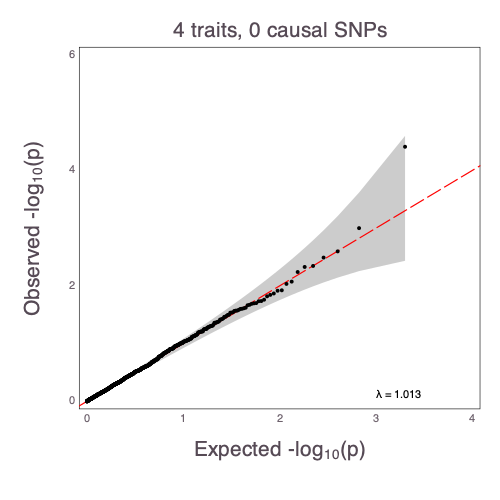

In [179]:
# only Poisson/Bernoulli traits
qq(pvals, dpi=100, titles="4 traits, $k causal SNPs")
display("image/png", read("qqplot.png"))

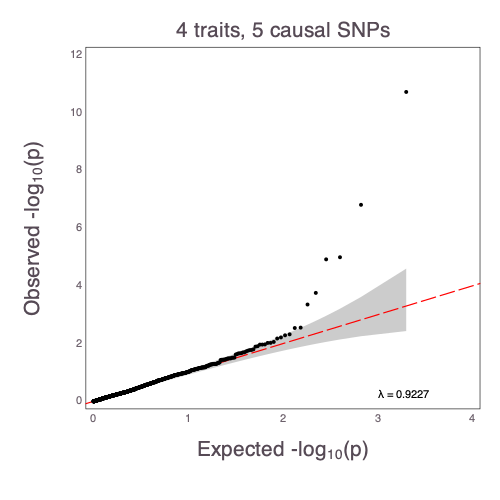

In [242]:
# only Poisson/Bernoulli traits
qq(pvals, dpi=100, titles="4 traits, $k causal SNPs")
display("image/png", read("qqplot.png"))

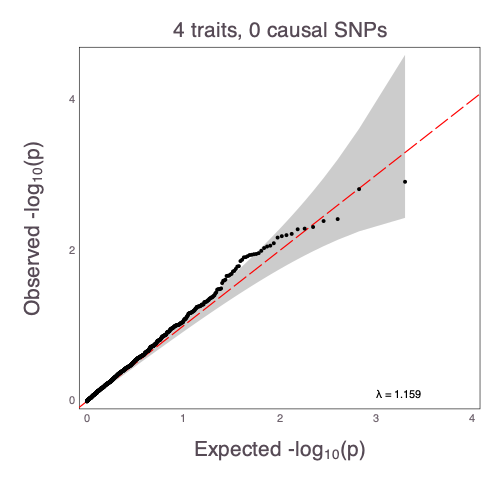

In [25]:
# includes gaussian traits
qq(pvals, dpi=100, titles="4 traits, $k causal SNPs")
display("image/png", read("qqplot.png"))

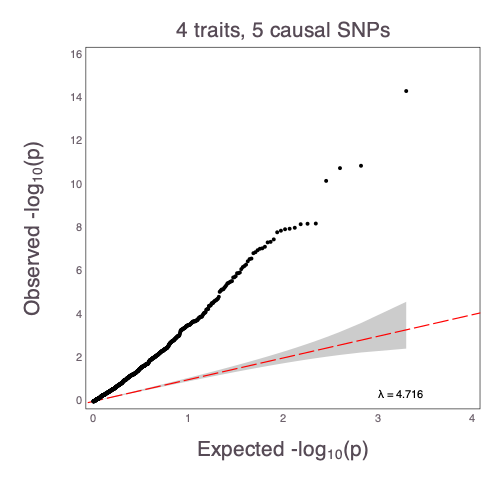

In [130]:
# includes gaussian traits
qq(pvals, dpi=100, titles="4 traits, $k causal SNPs")
display("image/png", read("qqplot.png"))